# LLM Interface
The `effectful.handlers.llm` module provides a simplified LLM interface that uses algebraic effects for modularity. The module interface consists of:

- A decorator `Template.define` which creates a prompt template from a callable. A template is an LLM-implemented function whose behavior is specified by a template string. When a template is called, an LLM is invoked to produce the specified behavior.
- A decorator `Tool.define` which exposes Python callables as tools that templates can call. Tool signatures and docstrings define the schema passed to the model.
- Structured output handling via `Encodable` (used internally by templates and tool calls) to serialize/deserialize Python types.
- LLM providers such as `LiteLLMProvider`, and reliability helpers like `RetryLLMHandler` and `ReplayLiteLLMProvider`, which can be composed with `handler(...)` to control execution.

In [1]:
import base64
import dataclasses
import functools
import inspect
import io
from collections.abc import Callable
from typing import Literal

import litellm
import pydantic
from IPython.display import HTML, display
from litellm.caching.caching import Cache
from PIL import Image
from pydantic import field_validator
from pydantic_core import PydanticCustomError

from effectful.handlers.llm import Template, Tool
from effectful.handlers.llm.completions import (
    LiteLLMProvider,
    RetryLLMHandler,
)
from effectful.handlers.llm.doctest import DoctestHandler
from effectful.handlers.llm.evaluation import UnsafeEvalProvider
from effectful.ops.semantics import NotHandled, handler

provider = LiteLLMProvider()

In the following sections, we walk through each of the mentioned components.

## Prompt Templates

This template function writes (bad) poetry on a given theme. While difficult to implement in Python, an LLM can provide a reasonable implementation.

In [2]:
@Template.define
def limerick(theme: str) -> str:
    """Write a limerick on the theme of {theme}. Do not use any tools."""
    raise NotHandled

If we call the template with a provider interpretation installed, we get reasonable behavior. The LLM is nondeterministic by default, so calling the template twice with the same arguments gives us different results.

Templates are regular callables, so can be converted to operations with `defop` if we want to override the LLM implementation in some cases.

In [3]:
with handler(provider):
    print(limerick("fish"))
    print("-" * 40)
    print(limerick("fish"))

There once was a fish quite spry,
Who wanted to soar through the sky.
He jumped with great flare,
Flew high in the air,
But found he was bound to fry.
----------------------------------------
There once was a fish who could sing,
He'd belt out tunes in the spring.
But once ice would form,
He'd switch to a norm—
Charming all with his fishy lip sync!


If we want deterministic behavior, we can cache the template call. We can either cache it with the default `@functools.cache` or use LiteLLM's built-in cache by setting a cache backend and passing `caching=True` to the provider:

In [4]:
@functools.cache
@Template.define
def haiku(theme: str) -> str:
    """Write a haiku on the theme of {theme}. Do not use any tools."""
    raise NotHandled


@Template.define
def haiku_no_cache(theme: str) -> str:
    """Write a haiku on the theme of {theme}. Do not use any tools."""
    raise NotHandled


print()
with handler(provider):
    print(haiku("fish"))
    print("-" * 40)
    print(haiku("fish"))

print()
# Enable LiteLLM caching by setting a cache backend and enabling caching.
litellm.cache = Cache()
provider_cached = LiteLLMProvider(caching=True)
try:
    with handler(provider_cached):
        print(haiku_no_cache("fish2"))
        print("-" * 40)
        print(haiku_no_cache("fish2"))
finally:
    litellm.cache = None

print()
with handler(provider):
    print(haiku_no_cache("fish3"))
    print("-" * 40)
    print(haiku_no_cache("fish3"))




Gleaming finned glides swift,  
Under ripples, life abounds,  
Silent waters hold.
----------------------------------------


Gleaming finned glides swift,  
Under ripples, life abounds,  
Silent waters hold.



/Users/nguyendat/Marc/effectful/.venv/lib/python3.12/site-packages/pydantic/main.py:528: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected 10 fields but got 6: Expected `Message` - serialized value may not be as expected [field_name='message', input_value=Message(content='{"value"...: None}, annotations=[]), input_type=Message])
  PydanticSerializationUnexpectedValue(Expected `StreamingChoices` - serialized value may not be as expected [field_name='choices', input_value=Choices(finish_reason='st...ider_specific_fields={}), input_type=Choices])
  return self.__pydantic_serializer__.to_json(


Silent waters swim,
Silver scales shimmer beneath—
Nature's quiet dance.
----------------------------------------
Gliding through cool streams,  
Silver scales in sunlight glow,  
Silent, swift they dart.

Beneath waves they glide,  
Scales flashing in sunlit beams,  
Silent wanderers.
----------------------------------------
Gliding scales shimmer,
Beneath rippling waters,
Silent whispers swim.


## Converting LLM Results to Python Objects

Type conversion is handled by `decode`. By default, primitive types are converted. `DecodeError` is raised if a response cannot be converted.

In [5]:
@Template.define
def primes(first_digit: int) -> int:
    """Give a prime number with {first_digit} as the first digit. Do not use any tools."""
    raise NotHandled


with handler(provider):
    assert type(primes(6)) is int

More complex types can be converted by providing handlers for `decode`. Callable synthesis is supported via `Encodable` and the evaluation providers in `effectful.handlers.llm.evaluation` (`UnsafeEvalProvider` or `RestrictedEvalProvider`), which enable parsing/compiling/executing synthesized code.

In [6]:
@Template.define
def count_char(char: str) -> Callable[[str], int]:
    """Write a function named count_char which takes a string and counts the occurrances of '{char}'. Do not use any tools."""
    raise NotHandled


# Use UnsafeEvalProvider for simple examples; RestrictedEvalProvider may need extra globals.
# DoctestHandler is not required for synthesis -- it is optional.
with handler(provider), handler(UnsafeEvalProvider()):
    count_a = count_char("a")
    assert callable(count_a)
    assert count_a("banana") == 3
    assert count_a("cherry") == 0
    # Print the source code of the generated function
    print(inspect.getsource(count_a))

def count_char(s: str) -> int:
    return s.count('a')


### Doctest Semantic Constraints

The `DoctestHandler` uses `>>>` examples in template docstrings as **semantic constraints** rather than literal prompts. It handles two cases automatically based on the template's return type:

- **Case 1 (tool-calling)**: When the template returns a non-`Callable` type (e.g. `str`, `int`), the handler runs a *calibration loop* once per template definition — calling the LLM with the doctest inputs, checking outputs, and caching the full conversation (including any corrections) as a few-shot prefix for future calls.
- **Case 2 (code generation)**: When the template returns a `Callable` type, the generated code must pass the doctests. A `ResultDecodingError` is raised on failure.

Notes: *In both cases, `>>>` examples are **stripped from the prompt** so the LLM cannot simply memorise the expected outputs.*



#### Case 1: Tool-Calling Calibration

For templates that return a non-`Callable` type (e.g. `str`), `DoctestHandler` runs a calibration loop the first time the template is called. It invokes the LLM with each doctest input, checks whether the output matches, and appends corrective feedback if not. The entire conversation — successes *and* failures — is cached as a few-shot prefix that teaches the LLM the template's expected behaviour.

In [7]:
@Template.define
def summarize_doctest(text: str) -> str:
    """Summarize the following text into a single concise sentence: '{text}'

    >>> summarize_doctest("The quick brown fox jumps over the lazy dog near the river bank on a sunny afternoon.")
    'A fox jumps over a lazy dog by a river on a sunny day.'
    >>> summarize_doctest("What a beautiful day!")
    'A beautiful day!'
    """
    raise NotHandled


# Without DoctestHandler: the template works, but the LLM has no calibration prefix.
with handler(provider):
    result_no_doctest = summarize_doctest(
        "Python is a high-level programming language known for its readability."
    )
    print(f"Without DoctestHandler: {result_no_doctest}")

# With DoctestHandler: calibration runs once, building a few-shot prefix.
# Subsequent calls benefit from the prefix.
doctest_handler = DoctestHandler()
with handler(provider), handler(doctest_handler):
    result_with_doctest = summarize_doctest(
        "Python is a high-level programming language known for its readability."
    )
    print(f"With DoctestHandler:    {result_with_doctest}")

# The calibration prefix is cached for the template.
print(
    f"\nCalibration prefix cached: {summarize_doctest in doctest_handler._prefix_cache}"
)
print(
    f"Prefix messages: {len(doctest_handler._prefix_cache.get(summarize_doctest, []))}"
)

Without DoctestHandler: Python is a user-friendly, high-level programming language renowned for its readability.
With DoctestHandler:    Python is a high-level programming language valued for its readability.

Calibration prefix cached: True
Prefix messages: 4


#### Case 2: Code Generation Validation

When synthesising callable code, `DoctestHandler` validates that the generated function passes the doctests.
Without it, synthesis succeeds even if the docstring examples don't match the generated code.

In [8]:
from effectful.handlers.llm.completions import ResultDecodingError


@Template.define
def count_char_with_bad_doctest(char: str) -> Callable[[str], int]:
    """Write a function named count_char that counts the occurrances of '{char}'.
    Do not use any tools.

        >>> count_char("banana")
        999
    """
    raise NotHandled


# Without DoctestHandler: synthesis succeeds (doctest is NOT checked)
with handler(provider), handler(UnsafeEvalProvider()):
    count_a = count_char_with_bad_doctest("a")
    assert callable(count_a)
    print("Without DoctestHandler: synthesis succeeded (doctest not checked)")
    print(f"  count_a('banana') = {count_a('banana')}")

# With DoctestHandler: synthesis fails because the doctest expects 999 but gets 3
try:
    with handler(provider), handler(UnsafeEvalProvider()), handler(DoctestHandler()):
        count_a = count_char_with_bad_doctest("a")
except ResultDecodingError as e:
    print("With DoctestHandler: synthesis failed as expected")
    print(f"  Error: {type(e).__name__}")

Without DoctestHandler: synthesis succeeded (doctest not checked)
  count_a('banana') = 3
**********************************************************************
1 items had failures:
   1 of   1 in __main__.__template_doctest__
***Test Failed*** 1 failures.
With DoctestHandler: synthesis failed as expected
  Error: ResultDecodingError


## Tool Calling

`Operation`s defined in the lexical scope of a `Template` are automatically available for the LLM to call as tools. The description of these operations is inferred from their type annotations and docstrings.

Tool calls are mediated by a helper operation `tool_call`. Handling this operation allows tool use to be tracked or logged.

In [9]:
@Tool.define
def cities() -> list[str]:
    """Return a list of cities that can be passed to `weather`."""
    return ["Chicago", "New York", "Barcelona"]


@Tool.define
def weather(city: str) -> str:
    """Given a city name, return a description of the weather in that city."""
    status = {"Chicago": "cold", "New York": "wet", "Barcelona": "sunny"}
    return status.get(city, "unknown")


@Template.define  # cities and weather auto-captured from lexical scope
def vacation() -> str:
    """Use the provided tools to suggest a city that has good weather. Use only the `cities` and `weather` tools provided."""
    raise NotHandled


with handler(provider):
    print(vacation())

Based on the current weather conditions, Barcelona has sunny weather and would be a great choice for a city with good weather.


## Image Inputs

You can pass `PIL.Image.Image` values directly to templates.


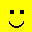

A simple digital smiley face with a yellow background and a basic black smile and eyes.


In [10]:
image_base64 = (
    "iVBORw0KGgoAAAANSUhEUgAAACAAAAAgCAYAAABzenr0AAAAhElEQVR4nO2W4QqA"
    "MAiEVXr/VzYWDGoMdk7Cgrt/sUs/DqZTd3EplFU2JwATYAJMoOlAB4bq89s95+Mg"
    "+gyAchsKAYplBBBA43hFhfxnUixDjdEUUL8hpr7R0KLdt9qElzcyiu8As+Kr8zQA"
    "mgLavAl+kIzFZyCRxtsAmWb/voZvqRzgBE1sIDuVFX4eAAAAAElFTkSuQmCC"
)
image = Image.open(io.BytesIO(base64.b64decode(image_base64)))


@Template.define
def describe_image(image: Image.Image) -> str:
    """Return a short description of the following image.
    {image}
    """
    raise NotHandled


with handler(provider):
    display(
        HTML(
            f'<img src="data:image/png;base64,{image_base64}" alt="Example image" width="320" />'
        )
    )
    print(describe_image(image))

## Structured Output Generation

Constrained generation is used for any type that is convertible to a Pydantic model.

In [11]:
@dataclasses.dataclass
class KnockKnockJoke:
    whos_there: str
    punchline: str


@Template.define
def write_joke(theme: str) -> KnockKnockJoke:
    """Write a knock-knock joke on the theme of {theme}. Do not use any tools."""
    raise NotHandled


@Template.define
def rate_joke(joke: KnockKnockJoke) -> bool:
    """Decide if {joke} is funny or not. Do not use any tools."""
    raise NotHandled


def do_comedy():
    joke = write_joke("lizards")
    print("> You are onstage at a comedy club. You tell the following joke:")
    print(
        f"Knock knock.\nWho's there?\n{joke.whos_there}.\n{joke.whos_there} who?\n{joke.punchline}"
    )
    if rate_joke(joke):
        print("> The crowd laughs politely.")
    else:
        print("> The crowd stares in stony silence.")


with handler(provider):
    do_comedy()

> You are onstage at a comedy club. You tell the following joke:
Knock knock.
Who's there?
Lizard.
Lizard who?
Lizard who? Lizard you always telling people not to take life's scaly bits too seriously!
> The crowd laughs politely.


## Template Composition

Templates defined in the lexical scope are also captured, enabling template composition. One template can use the result of another template in a pipeline:


In [12]:
# Sub-templates for different story styles
@Template.define
def story_with_moral(topic: str) -> str:
    """Write a short story about {topic} and end with a moral lesson. Do not use any tools."""
    raise NotHandled


@Template.define
def story_funny(topic: str) -> str:
    """Write a funny, humorous story about {topic}. Do not use any tools."""
    raise NotHandled


# Main orchestrator template - has access to sub-templates
@Template.define
def write_story(topic: str, style: str) -> str:
    """Write a story about {topic} in the style: {style}.
    Available styles: 'moral' for a story with a lesson, 'funny' for humor. Use story_funny for humor, story_with_moral for a story with a lesson."""
    raise NotHandled


# Verify sub-templates are captured in write_story's lexical context
assert story_with_moral in write_story.tools.values()
assert story_funny in write_story.tools.values()
print("Sub-templates available to write_story:", write_story.tools.keys())

with handler(provider):
    print("=== Story with moral ===")
    print(write_story("a curious cat", "moral"))
    print()
    print("=== Funny story ===")
    print(write_story("a curious cat", "funny"))

Sub-templates available to write_story: dict_keys(['limerick', 'haiku_no_cache', 'primes', 'count_char', 'summarize_doctest', 'count_char_with_bad_doctest', 'cities', 'weather', 'vacation', 'describe_image', 'write_joke', 'rate_joke', 'story_with_moral', 'story_funny'])
=== Story with moral ===


And so, Whiskers learned to balance her adventurous spirit with a touch of caution, prompting others to respect her wise curiosity as she continued to discover the world's wonders.

=== Funny story ===
 🐱😂


## Retrying LLM Requests
LLM calls can sometimes fail due to transient errors or produce invalid outputs. The `RetryLLMHandler` automatically retries failed template calls and can also surface tool/runtime errors as tool messages:

- `num_retries`: Maximum number of retry attempts (default: 3)
- `include_traceback`: When `True`, include traceback details in the error feedback (default: False)
- `catch_tool_errors`: Exception type(s) to catch during tool execution (default: `Exception`)


Example usage: having an unstable service that seldomly fail.

In [13]:
call_count = 0
REQUIRED_RETRIES = 3


@Tool.define
def unstable_service() -> str:
    """Fetch data from an unstable external service. May require retries."""
    global call_count
    call_count += 1
    if call_count < REQUIRED_RETRIES:
        raise ConnectionError(
            f"Service unavailable! Attempt {call_count}/{REQUIRED_RETRIES}. Please retry."
        )
    return "{ 'status': 'ok', 'data': [1, 2, 3] }"


@Template.define  # unstable_service auto-captured from lexical scope
def fetch_data() -> str:
    """Use the unstable_service tool to fetch data."""
    raise NotHandled


with handler(provider):
    try:
        result = fetch_data()
    except Exception as e:
        print(f"Error: {e}")

with handler(provider), handler(RetryLLMHandler(num_retries=3)):
    result = fetch_data()
    print(f"Result: {result}", "Retries:", call_count)

Error: Service unavailable! Attempt 1/3. Please retry.
Result: The data retrieved from the unstable service is: `[1, 2, 3]`. The service eventually responded successfully on the second attempt. Retries: 3


## Retrying with Validation Errors
As noted above, the `RetryHandler` can also be used to retry on runtime/validation error:

In [14]:
@pydantic.dataclasses.dataclass
class Rating:
    score: int
    explanation: str

    @field_validator("score")
    @classmethod
    def check_score(cls, v):
        if v < 1 or v > 5:
            raise PydanticCustomError(
                "invalid_score",
                "score must be 1–5, got {v}",
                {"v": v},
            )
        return v

    @field_validator("explanation")
    @classmethod
    def check_explanation_contains_score(cls, v, info):
        score = info.data.get("score", None)
        if score is not None and str(score) not in v:
            raise PydanticCustomError(
                "invalid_explanation",
                "explanation must mention the score {score}, got '{explanation}'",
                {"score": score, "explanation": v},
            )
        return v


@Template.define
def give_rating_for_movie(movie_name: str) -> Rating:
    """Give a rating for {movie_name}. The explanation MUST include the numeric score. Do not use any tools."""
    raise NotHandled


with handler(provider):
    try:
        rating = give_rating_for_movie("Die Hard")
    except Exception as e:
        print(f"Error: {e}")

with handler(provider), handler(RetryLLMHandler(num_retries=3)):
    rating = give_rating_for_movie("Die Hard")
    print(f"Score: {rating.score}/5")
    print(f"Explanation: {rating.explanation}")

Error: Error decoding response: 1 validation error for Response
value.score
  score must be 1–5, got 9 [type=invalid_score, input_value=9, input_type=int]. Please provide a valid response and try again.
Score: 5/5
Explanation: Die Hard is widely acclaimed as a quintessential action film, characterized by its intense narrative, well-crafted characters, and unforgettable lines. Bruce Willis's portrayal of John McClane remains iconic, solidifying the film's status in cinematic history. The film's masterful combination of action, humor, and suspense earns it a top score of 5 out of 5.


## Generating higher-order functions
Finally, we can generate higher-order functions that can call templates as well:

In [15]:
# Sub-templates for different story styles
@Template.define
def write_chapter(chapter_number: int, chapter_name: str) -> str:
    """Write a short story about {chapter_number}. Do not use any tools."""
    raise NotHandled


@Template.define
def judge_chapter(story_so_far: str, chapter_number: int) -> bool:
    """Decide if the new chapter is coherence with the story so far. Do not use any tools."""
    raise NotHandled


# Main orchestrator template - has access to sub-templates
@Template.define
def write_multi_chapter_story(style: Literal["moral", "funny"]) -> Callable[[str], str]:
    """Generate a function that writes a story in style: {style} about the given topic.
    Try to return the story no matter what.

    The program can use helper functions defined elsewhere (DO NOT REDEFINE THEM):
    - write_chapter(chapter_number: int, chapter_name: str) -> str
    - judge_chapter(story_so_far: str, chapter_number: int) -> bool"""
    raise NotHandled


# Verify sub-templates are captured in write_story's lexical context
print("Sub-templates available to write_story:", write_multi_chapter_story.tools.keys())

with (
    handler(RetryLLMHandler(num_retries=3)),
    handler(provider),
    handler(UnsafeEvalProvider()),
):
    print("=== Story with moral ===")
    function_that_writes_story = write_multi_chapter_story("moral")
    print(inspect.getsource(function_that_writes_story))
    print(function_that_writes_story("a curious cat"))
    print()

Sub-templates available to write_story: dict_keys(['limerick', 'haiku_no_cache', 'primes', 'count_char', 'summarize_doctest', 'count_char_with_bad_doctest', 'cities', 'weather', 'vacation', 'describe_image', 'write_joke', 'rate_joke', 'story_with_moral', 'story_funny', 'write_story', 'unstable_service', 'fetch_data', 'give_rating_for_movie', 'write_chapter', 'judge_chapter'])
=== Story with moral ===
def write_story_moral(topic: str) -> str:
    story = ""
    chapter_number = 1

    # Write up to 10 chapters or until the story is coherent
    while chapter_number <= 10:
        chapter_name = f"Chapter {chapter_number} on {topic}"
        chapter = write_chapter(chapter_number, chapter_name)
        story += chapter + " "

        if judge_chapter(story, chapter_number):
            break

        chapter_number += 1

    return story.strip()
Once upon a time in the bustling city of Numeria, there stood a simple yet proud apartment building known as One Tower. Among its residents was 